### 전처리

> Data
- Input: FMguide에서 다운받은 excel 파일
- Output: csv file (아웃라이어 찾기, Stationary 적용 전 파일)

> Process
1. Excel 데이터 불러오고 기본 데이터프레임 형식으로 전처리
2. rf(risk free rate) 데이터(yfinance) 불러오기 및 데이터 병합
3. ROE 계산
4. COE 계산
5. GM 계산
6. 일반수익률 계산(n일 후 종목 종가 - 종목 종가 / 종목 종가)
7. 상대수익률 계산(종목 수익률 - 시장 수익률)
8. 데이터 내보내기

> 코드 구현 날짜
- 2023-11-01

> 개발환경
- Python version: 3.8.18

> 수정내용
- 수정날짜: 2023-11-08  
- 수정내용:
1. 전처리 코드 함수화
2. 새로 다운받은 20년치 데이터 중 최근 10년 데이터 전처리 및 각종 지표 계산

- 수정날짜: 2023-11-13
- 수정내용:  
1. ROE 계산법 변경
- 기존: 연도별 평균 ROE 계산  
예) 2020년 2분기 ROE = 2020년 1,2,3,4분기의 평균 계산  
2023년 2분기 경우에는 2023년 1,2분기의 평균값을 계산하였음.

- 변경후: 이동평균 ROE 계산(중첩하며 평균 ROE 계산)  
예) 2020년 2분기 ROE = 2019년 3,4분기와 2020년 1,2분기의 평균 계산

- 수정날짜: 2023-11-19
- 수정내용:
1. 변경된 ROE 계산법을 통해 ROE 계산에 필요한 모든 컬럼에 다 계단식 평균 구하기 적용

- 수정날짜: 2023-11-22
1. 우리 데이터  Dart 데이터와 비교 -> 동일
- 영업이익, 금융손익, EMS를 계단평균 적용
- COE 2년이동평균 계산(MA)
- 결과: 구한gm이 sustainable하지만 교수님이 기대하신 (1~2) 값 보다는 크게 나옴.
- 내일 모이는 분들 확인해보시고 아웃라이어로 판단되는 부분 제거, 시그마, 표준화 등 사용하여 gm 보고 가능하면 R^2 확인까지 해보면 좋을 것 같아요!

In [14]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import os

# 한글과 음수 부호가 제대로 표시되는 폰트로 변경
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 표시 문제 해결

### FMguide 데이터 가져오기

In [15]:
# 전처리 함수
def load_data_guide(filename, sheet_name):
    raw_df = pd.read_excel(filename, sheet_name=sheet_name)
    col = raw_df[11:12] # 컬럼명 가져오기
    data = raw_df[13:] # 데이터 가져오기
    df = pd.concat([col, data]) # 컬럼명, 데이터 병합
    df.columns = df.iloc[0] # 컬럼 지정
    df.drop(df.index[0], inplace=True) # 필요없는 첫 행 삭제
    df.rename(columns={df.columns[0]:'Date'}, inplace=True) # 첫번째 컬럼의 컬럼명 변경
    df['Date'] = pd.to_datetime(df['Date']) # 시간형태로 변환
    df = df[(df['Date'] >= start_dt) & (df['Date'] <= end_dt)] # 원하는 기간 설정
    return df

In [17]:
# 변수 정의

# 회사 리스트
company_list = ['SK텔레콤', 'KT', 'LG유플러스', '농심', 'CJ제일제당', '오뚜기', '현대차', '한국타이어', 'KB금융', '신한지주']
company = company_list[2] # 회사 선택

# 기간 설정 -> 10년치 데이터만 가져옴
start_dt = '2012-07-01'
end_dt = '2023-06-30'

# 엑셀 파일 경로
filename = '../FMguide_data/gm_model_20years.xlsx'

In [19]:
# 함수를 사용해서 파일 읽기
df = load_data_guide(filename, company)
print("회사명: ", company)
df.head()

회사명:  LG유플러스


11,Date,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),종가(원),총자본(천원),PBR(배)
2491,2012-07-02,-10336000,-56562000,173000,5510,3730074000,0.5607
2492,2012-07-03,-10336000,-56562000,173000,5570,3730074000,0.56681
2493,2012-07-04,-10336000,-56562000,173000,5530,3730074000,0.56274
2494,2012-07-05,-10336000,-56562000,173000,5530,3730074000,0.56274
2495,2012-07-06,-10336000,-56562000,173000,5470,3730074000,0.55663


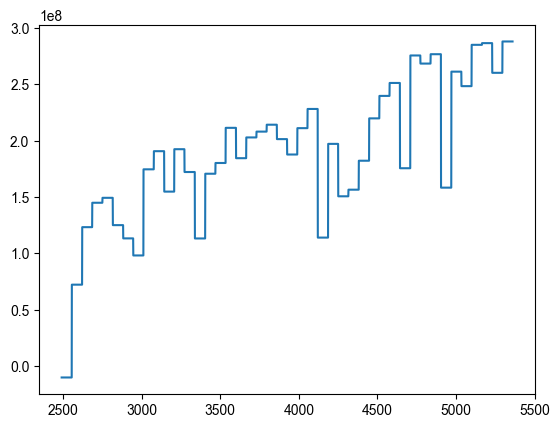

In [20]:
plt.plot(df['영업이익(천원)'])

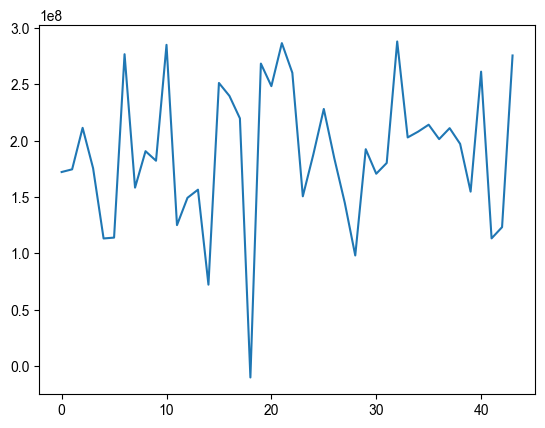

In [21]:
plt.plot(df['영업이익(천원)'].value_counts().index)

### COE 계산을 위한 rf 데이터 불러오기

- rf: risk free(미국채 10년물)

In [22]:
# 미국 국채 10년물 불러오는 함수
def load_us_10_year_data(start_date, end_date):
    us_10_year = yf.download("^TNX", start=start_date, end=end_date)
    us_10_year.rename(columns={'Close': 'us_10_treasury'}, inplace=True) # 컬럼명 변경
    us_10_year = us_10_year.reset_index() # Date(인덱스) -> 컬럼으로
    us_10_year = us_10_year[['Date', 'us_10_treasury']] # Date와 미국채 10년물만 가져오기
    return us_10_year

In [23]:
# 데이터 병합
us_10_year = load_us_10_year_data(start_dt, end_dt)
df = pd.merge(df, us_10_year, on='Date', how='outer') # 기존 df와 us_10_year데이터를 Date컬럼 기준으로 merge
df['us_10_treasury'] = df['us_10_treasury'].fillna(method='ffill') # us_10_treasury의 na 값을 ffill로(전날)데이터로 채워줌
#df = df.dropna() # NA인 행 삭제. NA라는 것은 영업일이 아니라는 의미이기 때문(공휴일인듯?)

[*********************100%%**********************]  1 of 1 completed


In [24]:
df['us_10_treasury_MA1Y'] = df['us_10_treasury'].rolling(window=240).mean()
df['us_10_treasury_MA2Y'] = df['us_10_treasury'].rolling(window=480).mean()

Text(0.5, 1.0, 'us_10_treasury')

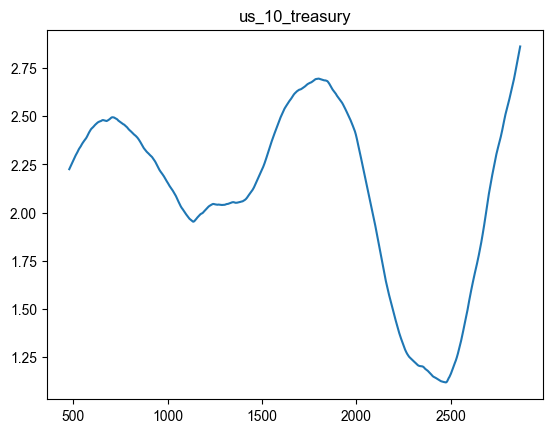

In [25]:
plt.plot(df['us_10_treasury_MA2Y'] )
plt.title('us_10_treasury')

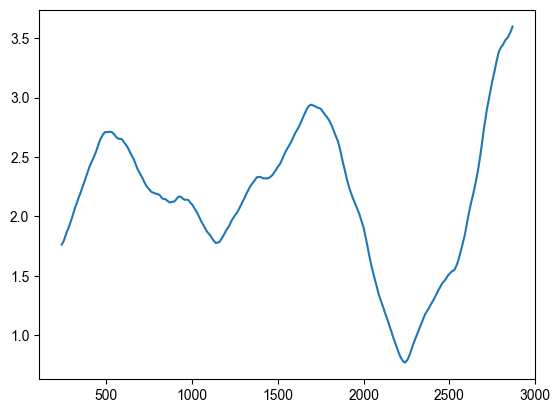

In [26]:
plt.plot(df['us_10_treasury_MA1Y'] )

### Equity(총자본(천원)) 계산

In [27]:
# 분기 나누는 함수
def get_quarter(date):
    year = date.year
    month = date.month

    if 2003 <= year <= 2023:
        if 1 <= month <= 3:
            return f'{year}Q1'
        elif 4 <= month <= 6:
            return f'{year}Q2'
        elif 7 <= month <= 9:
            return f'{year}Q3'
        elif 10 <= month <= 12:
            return f'{year}Q4'
    else:
        return None

In [28]:
df['Quarter'] = df['Date'].apply(get_quarter)

### COE 계산

COE = rf + Beta(MRP)

- Beta: 1
- MRP: 4%
- rf: 미국 국채 10년물

In [29]:
# beta랑 MRP 값
beta = 1
MRP = 4

In [30]:
df['COE'] = df['us_10_treasury'] + beta*MRP

In [31]:
df['COE_MA1Y'] = df['us_10_treasury_MA1Y'] + beta*MRP
df['COE_MA2Y'] = df['us_10_treasury_MA2Y'] + beta*MRP

Text(0.5, 1.0, 'COE')

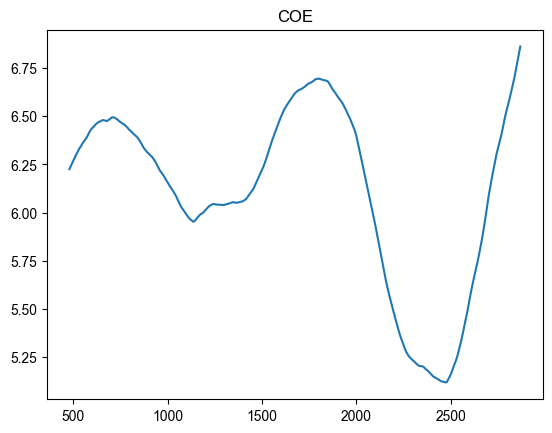

In [32]:
plt.plot(df['COE_MA2Y'])
plt.title("COE")

Text(0.5, 1.0, 'COE_MA1Y')

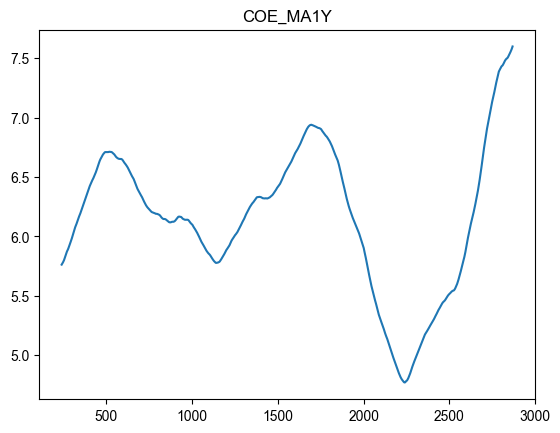

In [33]:
plt.plot(df['COE_MA1Y'])
plt.title("COE_MA1Y")

### ROE, Growth Multiplier 계산

- 순이익 = 영업이익 + 금융손익 + EMS *(1-20%)
- ROE = 순이익 / 총자본
- gm = PBR * COE / ROE

(1-20%): 법인세

In [34]:
# 년도와 분기를 포함한 컬럼 생성
df['YearQuarter'] = df['Date'].dt.to_period('Q')

In [35]:
#지수표현식 없애기
pd.options.display.float_format = '{:.5f}'.format


#되돌리기
pd.reset_option('display.float_format')

In [36]:
# 천원 단위 -> 원 단위
df['영업이익(원)'] = df['영업이익(천원)'] * 1000
df['금융손익(비영업)(원)'] = df['금융손익(비영업)(천원)'] * 1000
df['관계기업투자등관련손익(비영업)(원)'] = df['관계기업투자등관련손익(비영업)(천원)'] * 1000
df['총자본(원)'] = df['총자본(천원)'] * 1000

# 천원 단위 컬럼 삭제
df.drop(columns=['영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '총자본(천원)'], inplace=True)

In [37]:
df.head(3)

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원)
0,2012-07-02,5510,0.5607,1.580,NaN,NaN,2012Q3,5.580,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000
1,2012-07-03,5570,0.56681,1.631,NaN,NaN,2012Q3,5.631,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000
2,2012-07-04,5530,0.56274,1.631,NaN,NaN,2012Q3,5.631,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000


In [38]:
df.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)'],
      dtype='object')

In [39]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
gr_yq_df = df.groupby('YearQuarter').agg({
    '영업이익(원)': 'first',
    '금융손익(비영업)(원)': 'first',
    '관계기업투자등관련손익(비영업)(원)': 'first',
    '총자본(원)': 'first'
})

# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = gr_yq_df[column].astype(int)

In [40]:
gr_yq_df

,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원)
YearQuarter,,,,
2012Q3,-10336000000,-56562000000,173000000,3730074000000
2012Q4,72084000000,-60772000000,-79000000,3748500000000
2013Q1,123153000000,-36864000000,301000000,3820191000000
2013Q2,144818000000,-49885000000,213000000,3907798000000
2013Q3,149210000000,-48767000000,216000000,3981683000000
2013Q4,124948000000,-61094000000,249000000,4022616000000
2014Q1,113185000000,-44736000000,442000000,3983603000000
2014Q2,98026000000,-69360000000,507000000,4013886000000
2014Q3,174509000000,-52236000000,89000000,4103313000000


In [41]:
# 계단 평균의 이동평균을 계산하는 함수 정의
def move_mean(data, window_size=4):
    M = [None] * (window_size - 1)  # 첫 window_size - 1개는 NA로 채움
    for n in range(len(data) - window_size + 1):
        move_mean = sum(data[n:n+window_size]) / window_size
        M.append(int(move_mean))  # 계산된 이동 평균을 정수형으로 변환
    return M


In [42]:
# 각 컬럼에 대해 이동 평균을 계산
for column in ['영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)', '총자본(원)']:
    gr_yq_df[column + '_mean'] = move_mean(gr_yq_df[column])

gr_yq_df.tail(10)

,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean
YearQuarter,,,,,,,,
2021Q1,275617000000,-25232000000,422000000,7654154000000,2.355028e+11,-2.481725e+10,4.512500e+08,7.661567e+12
2021Q2,268420000000,-21510000000,431000000,7850809000000,2.426805e+11,-2.442350e+10,4.765000e+08,7.757103e+12
2021Q3,276739000000,-25298000000,545000000,7902636000000,2.490638e+11,-2.465700e+10,4.022500e+08,7.764703e+12
2021Q4,158238000000,-24575000000,914000000,7958558000000,2.447535e+11,-2.415375e+10,5.780000e+08,7.841539e+12
2022Q1,261246000000,-32221000000,910000000,7975956000000,2.411608e+11,-2.590100e+10,7.000000e+08,7.921990e+12
2022Q2,248374000000,-32549000000,489000000,8212179000000,2.361492e+11,-2.866075e+10,7.145000e+08,8.012332e+12
2022Q3,285067000000,-45993000000,1704000000,8313281000000,2.382312e+11,-3.383450e+10,1.004250e+09,8.114994e+12
2022Q4,286573000000,-55101000000,231000000,8449667000000,2.703150e+11,-4.146600e+10,8.335000e+08,8.237771e+12
2023Q1,260212000000,-57482000000,-396000000,8428711000000,2.700565e+11,-4.778125e+10,5.070000e+08,8.350960e+12


In [43]:
# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = pd.to_numeric(gr_yq_df[column], errors='coerce').astype('Int64')

In [44]:
gr_yq_df.columns

Index(['영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)', '총자본(원)',
       '영업이익(원)_mean', '금융손익(비영업)(원)_mean', '관계기업투자등관련손익(비영업)(원)_mean',
       '총자본(원)_mean'],
      dtype='object')

In [45]:
df_cleaned = pd.merge(df, gr_yq_df[['영업이익(원)_mean', '금융손익(비영업)(원)_mean', '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean']], on='YearQuarter')

In [46]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean'],
      dtype='object')

In [47]:
df_cleaned = df_cleaned.dropna()

In [48]:
df_cleaned['순이익'] = (df_cleaned['영업이익(원)_mean'] + df_cleaned['금융손익(비영업)(원)_mean'] + df_cleaned['관계기업투자등관련손익(비영업)(원)_mean']) * 0.8

In [49]:
df_cleaned.head(5)

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2014Q2,6.591,6.687496,6.225065,2014Q2,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0
482,2014-05-07,9870,1.0741,2.590,2.693433,2.231219,2014Q2,6.590,6.693433,6.231219,2014Q2,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2014Q2,6.602,6.695629,6.233312,2014Q2,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2014Q2,6.623,6.697554,6.235560,2014Q2,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2014Q2,6.656,6.699392,6.237942,2014Q2,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0


In [50]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean', '순이익'],
      dtype='object')

In [51]:
df_filtered = df_cleaned[df_cleaned['Date'] >= '2020-01-01']
df_filtered

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익
1958,2020-01-02,13850,0.85774,1.882,2.083292,2.504896,2020Q1,5.882,6.083292,6.504896,2020Q1,219757000000,-20506000000,-767000000,7319587000000,177222250000,-22325500000,19750000,7149347250000,123933200000.0
1959,2020-01-03,13800,0.85465,1.788,2.079529,2.502669,2020Q1,5.788,6.079529,6.502669,2020Q1,219757000000,-20506000000,-767000000,7319587000000,177222250000,-22325500000,19750000,7149347250000,123933200000.0
1960,2020-01-06,13600,0.84226,1.811,2.075725,2.500440,2020Q1,5.811,6.075725,6.500440,2020Q1,219757000000,-20506000000,-767000000,7319587000000,177222250000,-22325500000,19750000,7149347250000,123933200000.0
1961,2020-01-07,13800,0.85465,1.827,2.072079,2.498252,2020Q1,5.827,6.072079,6.498252,2020Q1,219757000000,-20506000000,-767000000,7319587000000,177222250000,-22325500000,19750000,7149347250000,123933200000.0
1962,2020-01-08,13450,0.83297,1.874,2.068629,2.496150,2020Q1,5.874,6.068629,6.496150,2020Q1,219757000000,-20506000000,-767000000,7319587000000,177222250000,-22325500000,19750000,7149347250000,123933200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2023-06-26,11000,0.56781,3.719,3.580583,2.840927,2023Q2,7.719,7.580583,6.840927,2023Q2,288042000000,-52261000000,1045000000,8641735000000,279973500000,-52709250000,646000000,8458348500000,182328200000.0
2866,2023-06-27,11090,0.57246,3.768,3.584671,2.846090,2023Q2,7.768,7.584671,6.846090,2023Q2,288042000000,-52261000000,1045000000,8641735000000,279973500000,-52709250000,646000000,8458348500000,182328200000.0
2867,2023-06-28,11140,0.57504,3.710,3.588737,2.851023,2023Q2,7.710,7.588737,6.851023,2023Q2,288042000000,-52261000000,1045000000,8641735000000,279973500000,-52709250000,646000000,8458348500000,182328200000.0
2868,2023-06-29,10690,0.55181,3.854,3.593625,2.856256,2023Q2,7.854,7.593625,6.856256,2023Q2,288042000000,-52261000000,1045000000,8641735000000,279973500000,-52709250000,646000000,8458348500000,182328200000.0


In [52]:
df_cleaned['ROE'] = df_cleaned['순이익'] / df_cleaned['총자본(원)_mean']
df_cleaned['ROE'] = df_cleaned['ROE']*100

Text(0.5, 1.0, 'ROE(Before)')

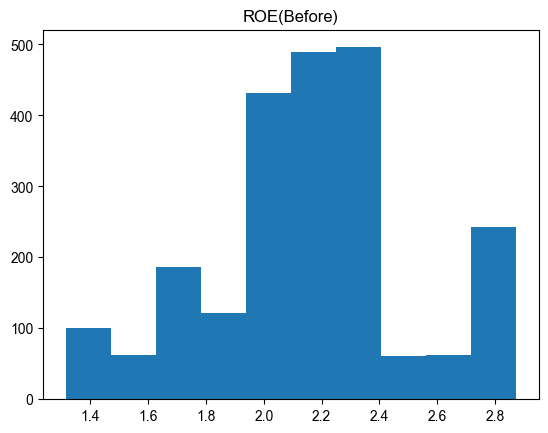

In [53]:
plt.hist(df_cleaned['ROE'])
plt.title('ROE(Before)')

In [38]:
df_cleaned.head()

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,...,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2014Q2,6.591,6.687496,6.225065,...,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0,1.313983
482,2014-05-07,9870,1.0741,2.590,2.693433,2.231219,2014Q2,6.590,6.693433,6.231219,...,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0,1.313983
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2014Q2,6.602,6.695629,6.233312,...,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0,1.313983
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2014Q2,6.623,6.697554,6.235560,...,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0,1.313983
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2014Q2,6.656,6.699392,6.237942,...,98026000000,-69360000000,507000000,4013886000000,121342250000,-55989250000,353500000,4000447000000,52565200000.0,1.313983


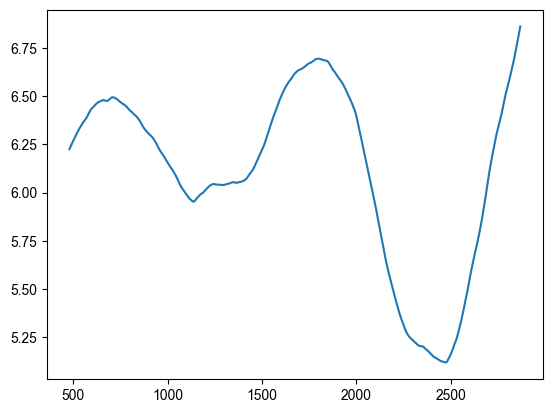

In [39]:
plt.plot(df_cleaned['COE_MA2Y'] )

In [40]:
df_cleaned['gm'] = df_cleaned['PBR(배)'] *  df_cleaned['COE_MA2Y'] /  df_cleaned['ROE']

In [41]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
df_cleaned_gr = df_cleaned.groupby('YearQuarter').agg({
    'ROE': 'first',
    'gm': 'first',
    'COE_MA2Y': 'first'
})

df_cleaned_gr

,ROE,gm,COE_MA2Y
YearQuarter,,,
2014Q2,1.313983,5.181414,6.225065
2014Q3,1.411755,4.43892,6.311035
2014Q4,1.681711,4.948559,6.420835
2015Q1,1.855619,4.215049,6.479225
2015Q2,2.373909,2.978301,6.492690
2015Q3,2.3499,2.664257,6.445265
2015Q4,2.060701,3.736975,6.378152
2016Q1,2.170142,2.901966,6.291073
2016Q2,2.159806,3.033667,6.190835


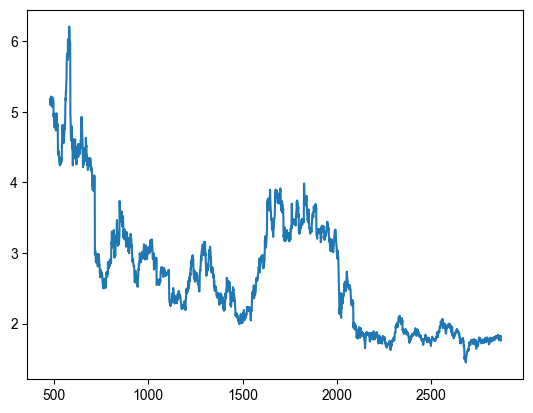

In [42]:
plt.plot(df_cleaned['gm'])

In [44]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean', '순이익', 'ROE', 'gm'],
      dtype='object')

In [49]:
# 모든 행 출력되도록
#pd.set_option('display.max_rows', None)

# 모든 컬럼 출력
#pd.set_option('display.max_columns', None)

### 시점&수익률 생성

In [50]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['종가_1주후'] = df['종가(원)'].shift(-5) # 1주
df['종가_2주후'] = df['종가(원)'].shift(-10) # 2주
df['종가_1달후'] = df['종가(원)'].shift(-20) # 1달
df['종가_3달후'] = df['종가(원)'].shift(-60) # 3달
df['종가_6달후'] = df['종가(원)'].shift(-120) # 6달

### 일반 수익률

In [51]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['수익률_1주후'] = (df['종가_1주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_2주후'] = (df['종가_2주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_1달후'] = (df['종가_1달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_3달후'] = (df['종가_3달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_6달후'] = (df['종가_6달후'] - df['종가(원)']) / df['종가(원)'] * 100

### 코스피(시장) 수익률 계산

In [52]:
# 코스피 지수 데이터 가져오기
df_kospi = yf.download('^KS11', start_dt, end_dt)
df_kospi = df_kospi.reset_index() # index -> column
df = df.merge(df_kospi[['Date', 'Adj Close']]) # df에 df_kospi "Adj Close" 값 병합
df.rename(columns={'Adj Close': 'kospi'}, inplace=True) # 컬럼명 변경

[*********************100%%**********************]  1 of 1 completed


In [53]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['kospi_1주후'] = df['kospi'].shift(-5) # 1주
df['kospi_2주후'] = df['kospi'].shift(-10) # 2주
df['kospi_1달후'] = df['kospi'].shift(-20) # 1달
df['kospi_3달후'] = df['kospi'].shift(-60) # 3달
df['kospi_6달후'] = df['kospi'].shift(-120) # 6달

In [54]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['kospi_수익률_1주후'] = (df['kospi_1주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_2주후'] = (df['kospi_2주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_1달후'] = (df['kospi_1달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_3달후'] = (df['kospi_3달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_6달후'] = (df['kospi_6달후'] - df['kospi']) / df['kospi'] * 100

In [55]:
# 지수를 얼마나 이겼는지 (상대)수익률
df['상대수익률_1주후'] = df['수익률_1주후'] - df['kospi_수익률_1주후']
df['상대수익률_2주후'] = df['수익률_2주후'] - df['kospi_수익률_2주후']
df['상대수익률_1달후'] = df['수익률_1달후'] - df['kospi_수익률_1달후']
df['상대수익률_3달후'] = df['수익률_3달후'] - df['kospi_수익률_3달후']
df['상대수익률_6달후'] = df['수익률_6달후'] - df['kospi_수익률_6달후']

### 데이터 내보내기

In [ ]:
# # 저장할 폴더 경로 지정
# folder_path = '../gm_data'

# # 폴더가 없으면 생성
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # CSV 파일 저장
# df.to_csv(f'{folder_path}/{company}_df.csv', index=False)


In [61]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean', '순이익', 'ROE', 'gm'],
      dtype='object')